In [1]:
import os
import time
import numpy as np
from Networks import *
from loss import *
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES']='4'

In [2]:
import glob
# X = glob.glob('/data4/PCT/Journal_MAR/pj_metals/*.mat')
X = glob.glob('/data4/PCT/Journal_MAR/pj_metals/*')
from sklearn.cross_validation import train_test_split
X_train, X_val, _, _ = train_test_split(X, X, test_size=0.5, random_state=42)

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. 

In [3]:
print(len(X_train))

3488


In [4]:
from skimage import transform
import cv2
class SinogramDataset(Dataset):
    def __init__(self, file_path_list, phase='train'):
        self.path_list = file_path_list
        self.phase = phase
    
    def __getitem__(self, index):
        
        Sinogram_target,Sinogram_LI, Image_LI, Image_target,mask,Sinogram_target1 = self.load_data(self.path_list[index])
        
        return Sinogram_target,Sinogram_LI, Image_LI, Image_target,mask,Sinogram_target1
    
    def load_data(self, file_path):
        metal_sinogram = sio.loadmat(file_path)['pj_metal']
#         metal_sinogram = sio.loadmat(file_path, verify_compressed_data_integrity=False)['Crop_metal']
        group_num=file_path.split('/')[-1].split('_')[0]
        slice_num=file_path.split('/')[-1].split('_')[1]
        Sinogram_target = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/pj_GroundTruth/','{}_{}_GroundTruth.mat'.format(group_num,slice_num)))['pj_GroundTruth']
        Image_target = np.load(os.path.join('/data4/PCT/Journal_MAR/Image_GroundTruth/','{}_{}_GroundTruth.npy'.format(group_num,slice_num)))
        Sinogram_LI = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/LI_Sinograms/','_'.join(file_path.split('/')[-1].split('_')[0:3])+'_LISinograms.mat'))['Sinogram_LI']
        Image_LI = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/LI_Images/','_'.join(file_path.split('/')[-1].split('_')[0:3])+'_LIImages.mat'))['Image_LI']
        mask = metal_sinogram == 0
        Sinogram_target1 = Sinogram_target
#         prior_image = sio.loadmat('/data4/PCT/Artifact_Reducaion/hip dataset/hip_pj_OriginalCT/hip2_182_GroundTruth.mat')['pj_GroundTruth']
        Sinogram_target,Sinogram_LI, mask= self.process_data(Sinogram_target,Sinogram_LI, mask)
        Image_target = Image_target.astype(np.float32)[np.newaxis,:,:]
        Sinogram_target1 = Sinogram_target1.astype(np.float32)[np.newaxis,:,:]
#         Sinogram_LI = Sinogram_LI.astype(np.float32)[np.newaxis,:,:]
        Image_LI = Image_LI.astype(np.float32)[np.newaxis,:,:]
#         mask = mask.astype(np.float32)[np.newaxis,:,:]
#         prior_image = prior_image[np.newaxis,:,:]
        return Sinogram_target,Sinogram_LI, Image_LI, Image_target,mask,Sinogram_target1
        
    def process_data(self, *args):
        return [item[np.newaxis, :, 176:-176].astype(np.float32) for item in args]
#         return [item[np.newaxis, :, :].astype(np.float32) for item in args]
    
    def __len__(self):
        return len(self.path_list)

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
batch_size =4
num_workers = 4

trainset = SinogramDataset(file_path_list=X_train, phase='train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# valset = SinogramDataset(file_path_list=X_val, phase='val')
# val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
torch.backends.cudnn.benchmark = True
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda:0')

In [7]:
# from models.hourglass import Hourglass
from fan_fbp import *
from fan_projection.modules.fan_projection import FanProj

class CombineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.UNet_CVPR1 = UNet_CVPR1()        
#         self.hourglass = Hourglass(1, 1, 3)
#         self.fbp_model = FanFBP(512, 512)
#         self.proj_model = FanProj(720, 1024)
        self.ImageDomainNetwork = UNet_CVPR2()
#         self.post_processing = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(True),
#                                              nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(True),
#                                              nn.Conv2d(64, 1, kernel_size=1))
    
    def forward(self, Sinogram_LI,Image_LI,mask,Sinogram_target1):
        
        out_Inpainting = self.UNet_CVPR1(Sinogram_LI)
        out_Inpainting = Sinogram_LI * mask + out_Inpainting * (1 - mask)
        new_Inpainting = Sinogram_target1
        new_Inpainting[:,:,:,176:-176] = out_Inpainting
        Processed_Image = self.ImageDomainNetwork(FanFBP(512, 512)(new_Inpainting),Image_LI)
        
        return out_Inpainting,Processed_Image

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
device_ids = [0,1,2,5]

model = CombineModel().cuda(device_ids[0])

# Dis= DiscriminativeNet()
# checkpoint1 = torch.load('/data4/PCT/Artifact_Reducaion/CBCT dataset/models_CGAN_with_prior_image/CGAN_final_dis/checkpoint_497.pth.tar', map_location="cuda:0")
# Dis.load_state_dict(checkpoint1['state_dict'])
# Dis.cuda(device_ids[0])

# # Gen = FusionGenPeceptual().cuda(device_ids[0])
# # # Gen = GenerativeNet().cuda(device_ids[0])
# # Dis = DiscriminativeNet().cuda(device_ids[0])
model = nn.DataParallel(model, device_ids=device_ids)
# Dis = nn.DataParallel(Dis, device_ids=device_ids)
print(model)

AssertionError: Invalid device id

In [9]:
from torch.optim.lr_scheduler import MultiStepLR
# if False:
#     lr = 5e-5
#     model.freeze_enc_bn = True
# optimizer_Gen = torch.optim.Adam(filter(lambda p: p.requires_grad, Gen.parameters()), lr=5e-4)
# optimizer_Gen = nn.DataParallel(optimizer_Gen, device_ids=device_ids)
# scheduler_Gen = MultiStepLR(optimizer_Gen.module, milestones=[150,300], gamma=0.3)

# criterion_Dis = nn.MSELoss().to(device)
# optimizer_Dis = torch.optim.Adam(Dis.parameters(),lr=1e-4)
# optimizer_Dis = nn.DataParallel(optimizer_Dis, device_ids=device_ids)
# scheduler_Dis = MultiStepLR(optimizer_Dis.module, milestones=[150,300], gamma=0.3)
criterion_1 = nn.L1Loss().to(device)
criterion2 = InpaintingLoss().to(device)#Inpainting areas
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.module.parameters()), lr=1e-4)
optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
scheduler = MultiStepLR(optimizer.module, milestones=[50,100,180,300,500], gamma=0.3)
# scheduler = MultiStepLR(optimizer.module, milestones=[50,150,220,350], gamma=0.5)

/home/pengchengtao/pct/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
def save_checkpoint(state, checkpoint='checkpoint', snapshot=1):
    if not os.path.exists(checkpoint): os.makedirs(checkpoint)
    if snapshot and state['epoch'] % snapshot == 0:
        torch.save(state, os.path.join(checkpoint, 'checkpoint_{}.pth.tar'.format(state['epoch'])))
        

In [11]:
import scipy.io as sio
step=0
epoches=600
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
model.train()
for epoch in range(0,epoches):
    print('epoch:' + str(epoch))
    scheduler.step()
    for i,data in enumerate(train_loader):
        Sinogram_target,Sinogram_LI, Image_LI, Image_target,mask,Sinogram_target1= [item for item in data]
        Sinogram_target = Sinogram_target.to(device)
        Sinogram_LI = Sinogram_LI.to(device)
        Image_LI = Image_LI.to(device)
        Image_target = Image_target.to(device)
        Sinogram_target1 = Sinogram_target1.to(device)
        mask = mask.to(device)
#         new_x, out_2, residual_x, out4= model(Sinogram_target, mask)
        out_Inpainting,Processed_Image= model(Sinogram_LI,Image_LI,mask,Sinogram_target1)
        loss_Inpainting = criterion_1(out_Inpainting,Sinogram_target)
        loss_Image= criterion_1(Processed_Image,Image_target)
        loss=loss_Inpainting + loss_Image
        
        if loss<50:
            optimizer.module.zero_grad()
            loss.backward()
            optimizer.module.step()
        
    print('Train_loss:  {}'.format(loss))
    print('Train_Loss_Inpainting:  {}'.format(loss_Inpainting))
    print('Train_loss_Image:  {}'.format(loss_Image))
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.module.state_dict(),
            }, checkpoint='/data6/PCT/Journal_MAR/DodomainNet_models/', snapshot=1)


    

epoch:0


/home/pengchengtao/pct/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Train_loss:  0.028462819755077362
Train_Loss_Inpainting:  0.012391087599098682
Train_loss_Image:  0.016071731224656105
epoch:1
Train_loss:  0.04623222351074219
Train_Loss_Inpainting:  0.016067584976553917
Train_loss_Image:  0.03016463667154312
epoch:2
Train_loss:  0.02758541703224182
Train_Loss_Inpainting:  0.014916728250682354
Train_loss_Image:  0.012668687850236893
epoch:3
Train_loss:  0.03793700411915779
Train_Loss_Inpainting:  0.02380765601992607
Train_loss_Image:  0.01412934809923172
epoch:4
Train_loss:  0.019513174891471863
Train_Loss_Inpainting:  0.007773302029818296
Train_loss_Image:  0.011739872395992279
epoch:5
Train_loss:  0.02204066887497902
Train_Loss_Inpainting:  0.011354036629199982
Train_loss_Image:  0.010686632245779037
epoch:6
Train_loss:  0.03241841495037079
Train_Loss_Inpainting:  0.01758670248091221
Train_loss_Image:  0.01483171060681343
epoch:7
Train_loss:  0.015075363218784332
Train_Loss_Inpainting:  0.005427348893135786
Train_loss_Image:  0.009648013859987259
ep

epoch:65
Train_loss:  0.014490623958408833
Train_Loss_Inpainting:  0.008424651809036732
Train_loss_Image:  0.006065972149372101
epoch:66
Train_loss:  0.01387508399784565
Train_Loss_Inpainting:  0.009025567211210728
Train_loss_Image:  0.004849516320973635
epoch:67
Train_loss:  0.014555703848600388
Train_Loss_Inpainting:  0.009443388320505619
Train_loss_Image:  0.005112315993756056
epoch:68
Train_loss:  0.013524100184440613
Train_Loss_Inpainting:  0.008174712769687176
Train_loss_Image:  0.005349387880414724
epoch:69
Train_loss:  0.01983770541846752
Train_Loss_Inpainting:  0.014580686576664448
Train_loss_Image:  0.005257019307464361
epoch:70
Train_loss:  0.008820517919957638
Train_Loss_Inpainting:  0.005118805915117264
Train_loss_Image:  0.0037017117720097303
epoch:71
Train_loss:  0.015727423131465912
Train_Loss_Inpainting:  0.010718652047216892
Train_loss_Image:  0.005008771549910307
epoch:72
Train_loss:  0.023214686661958694
Train_Loss_Inpainting:  0.0154836755245924
Train_loss_Image:  

Train_loss:  0.03079308569431305
Train_Loss_Inpainting:  0.022714536637067795
Train_loss_Image:  0.00807854812592268
epoch:130
Train_loss:  0.021111076697707176
Train_Loss_Inpainting:  0.01491488516330719
Train_loss_Image:  0.006196192000061274
epoch:131
Train_loss:  0.011690236628055573
Train_Loss_Inpainting:  0.006708163768053055
Train_loss_Image:  0.00498207239434123
epoch:132
Train_loss:  0.014557181857526302
Train_Loss_Inpainting:  0.008737058378756046
Train_loss_Image:  0.005820123478770256
epoch:133
Train_loss:  0.01841200888156891
Train_Loss_Inpainting:  0.012612554244697094
Train_loss_Image:  0.005799455102533102
epoch:134
Train_loss:  0.009488639421761036
Train_Loss_Inpainting:  0.004692401736974716
Train_loss_Image:  0.00479623768478632
epoch:135
Train_loss:  0.025531908497214317
Train_Loss_Inpainting:  0.01737736351788044
Train_loss_Image:  0.008154544979333878
epoch:136
Train_loss:  0.010372696444392204
Train_Loss_Inpainting:  0.0057079121470451355
Train_loss_Image:  0.004

Train_loss:  0.009091527201235294
Train_Loss_Inpainting:  0.005353204905986786
Train_loss_Image:  0.003738322528079152
epoch:194
Train_loss:  0.022373761981725693
Train_Loss_Inpainting:  0.015207735821604729
Train_loss_Image:  0.007166025694459677
epoch:195
Train_loss:  0.0074801454320549965
Train_Loss_Inpainting:  0.003570396453142166
Train_loss_Image:  0.00390974897891283
epoch:196
Train_loss:  0.011017474345862865
Train_Loss_Inpainting:  0.006730677559971809
Train_loss_Image:  0.004286796785891056
epoch:197
Train_loss:  0.01660173200070858
Train_Loss_Inpainting:  0.011169476434588432
Train_loss_Image:  0.00543225510045886
epoch:198
Train_loss:  0.005057334899902344
Train_Loss_Inpainting:  0.002310940297320485
Train_loss_Image:  0.0027463948354125023
epoch:199
Train_loss:  0.009764795191586018
Train_Loss_Inpainting:  0.006068906746804714
Train_loss_Image:  0.0036958884447813034
epoch:200
Train_loss:  0.012055987492203712
Train_Loss_Inpainting:  0.007308464031666517
Train_loss_Image: 

Process Process-1012:
Process Process-1009:
Process Process-1011:
Process Process-1010:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pengchengtao/pct/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_qu

In [33]:
model = CombineModel()
checkpoint = torch.load('/data6/PCT/Journal_MAR/DodomainNet_models/checkpoint_15.pth.tar', map_location="cuda:0")
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()
# 251 190 ---100 130 251 60

CombineModel(
  (UNet_CVPR1): UNet_CVPR1(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (conv5): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (up1): Upsample(scale_factor=2, mode=nearest)
    (conv6): Sequential(
      (0): Conv2d(320, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (up2): Upsample(scale_factor=2, mode=nearest)
    (conv7): Conv2d(160, 1, kernel_size=(3, 3), stride

In [9]:
# a=np.load('/data4/PCT/Journal_MAR/Image_GroundTruth/hip4_98_GroundTruth.npy')
# plt.imshow(a,cmap='gray')
# sio.savemat('/data4/PCT/Journal_MAR/a.mat',{'a':a})

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['/data4/PCT/Journal_MAR/pj_metals/dental_IM000007_2metals_metal.mat']


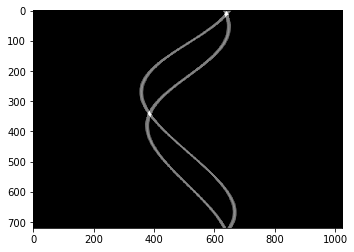

In [31]:
import scipy.io as sio
import matplotlib.pyplot as plt
file_path='/data4/PCT/Journal_MAR/pj_metals/dental_IM000007_2metals_metal.mat'
metal_sinogram=sio.loadmat(file_path)['pj_metal']
print(metal_sinogram)
plt.imshow(metal_sinogram,cmap='gray')
X_test=['/data4/PCT/Journal_MAR/pj_metals/dental_IM000007_2metals_metal.mat']
print(X_test)
valset = SinogramDataset(file_path_list=X_test, phase='val')
val_loader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=num_workers)

/home/pengchengtao/pct/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


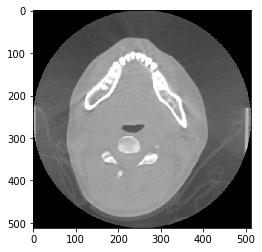

In [34]:
model.eval()
for i, (data) in enumerate(val_loader, 0):
    Sinogram_target,Sinogram_LI, Image_LI, Image_target,mask,Sinogram_target1= [item for item in data]
    Sinogram_target = Sinogram_target.to(device)
    Sinogram_LI = Sinogram_LI.to(device)
    Image_LI = Image_LI.to(device)
    Image_target = Image_target.to(device)
    Sinogram_target1 = Sinogram_target1.to(device)
    mask = mask.to(device)
    out_Inpainting,Processed_Image= model(Sinogram_LI,Image_LI,mask,Sinogram_target1)
# Image=FanFBP(512, 512)(new_x)
# print(Image.size())
# Image = Image[0,0,...].cpu().detach().numpy()
# plt.imshow(Image,cmap='gray',vmin=0.1,vmax=0.7)
# new_out = target * mask + outputs * (1-mask)
# new_out=new_out.cpu()
# new_out=new_out.detach().numpy()
Processed_Image = Processed_Image[0,0,...].cpu().detach().numpy()
Sinogram_target1 = Sinogram_target1[0,0,...].cpu().detach().numpy()
plt.figure()
plt.imshow(Processed_Image,cmap='gray',vmin=0.2,vmax=0.7)

out_Inpainting = out_Inpainting[0,0,...].cpu().detach().numpy()
Sinogram_target1[:,176:-176] =  out_Inpainting
# sio.savemat('/data6/PCT/Journal_MAR/RESULTS/Sinogram_TMI_vertebra2_58_22metals.mat', {'Sinogram_TMI':Sinogram_target1})
sio.savemat('/data4/PCT/Journal_MAR/result_TMI/Image_TMI3_dental_IM000007_2metals_metal.mat', {'Image_TMI3':Processed_Image})
# plt.imshow(new_x,cmap='gray')
# residual_x = residual_x[0,0,...].cpu().detach().numpy()
# plt.figure()
# plt.imshow(residual_x,cmap='gray')

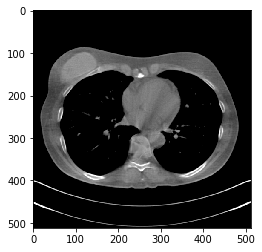

In [12]:
plt.imshow(Processed_Image,cmap='gray',vmin=0.2,vmax=0.7)
sio.savemat('/data6/PCT/Journal_MAR/RESULTS/Image_DoDomain.mat', {'Image_DoDomain':Processed_Image})

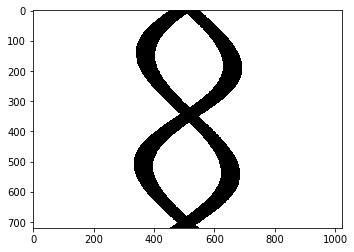

In [27]:
mask = mask[0,0,...].cpu().detach().numpy()
plt.figure()
plt.imshow(mask,cmap='gray')

torch.Size([1, 1, 720, 720])


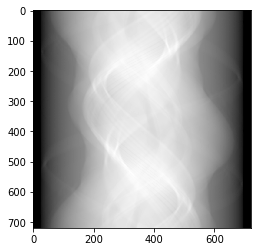

In [21]:
print(target.shape)
plt.imshow(target[0,0,:,:],cmap='gray')

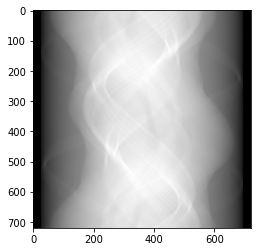

In [22]:
out1=new_out[0,0,:,:]
plt.imshow(out1,cmap='gray')

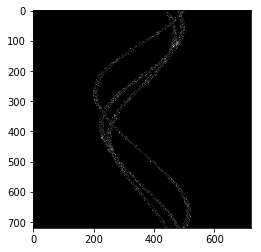

In [23]:
target=target.cpu().detach().numpy()
target1=target[0,0,:,:]
test=abs(target1-out1)

plt.imshow(test,cmap='gray')

torch.Size([1, 1, 512, 512])


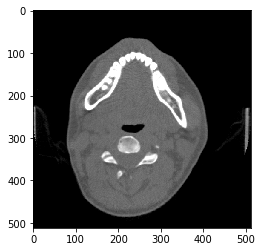

In [24]:
GroundTruth=sio.loadmat('/data4/PCT/Artifact_Reducaion/dental/pj_GroundTruth/dental_IM000007_GroundTruth.mat')['pj_GroundTruth']
plt.imshow(GroundTruth,cmap='gray')
# out1=np.resize(720,720)
result=GroundTruth
result[:,152:-152]=out1[:,:]
# result=out1
plt.imshow(result,cmap='gray')
result=torch.from_numpy(result).float().to(device)
result=result[np.newaxis,np.newaxis,:,:]
from fan_fbp import *
Image_CGAN=FanFBP(512, 512)(result)
print(Image_CGAN.size())
Image_CGAN=Image_CGAN[0,0,:,:]
Image_Proposed=Image_CGAN.cpu().numpy()
plt.imshow(Image_Proposed,cmap='gray',vmin=0.4,vmax=0.7)
sio.savemat('/data4/PCT/Task1/Image_Proposed_dental_IM000007_3metal.mat', {'Image_Proposed':Image_Proposed})

In [40]:
sio.savemat('/data4/PCT/Task1/cgan_dental_IM0000038_2metals_metal_result.mat', {'result':result}) 

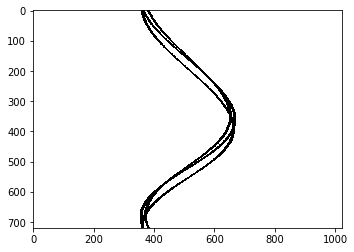

In [21]:
target=sio.loadmat('/data4/PCT/Artifact_Reducaion/vertebra dataset/vertebra_pj_OriginalCT/vertebra2_150_GroundTruth.mat')['pj_GroundTruth']
file_path='/data4/PCT/Artifact_Reducaion/vertebra dataset/vertebra_pj_metals/vertebra2_150_3metals_metal.mat'
test=sio.loadmat(file_path)['pj_metal']
mask = test == 0
plt.imshow(mask,'gray')

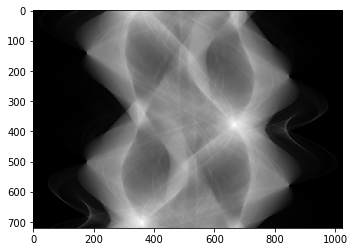

In [22]:
plt.imshow(target,cmap='gray')

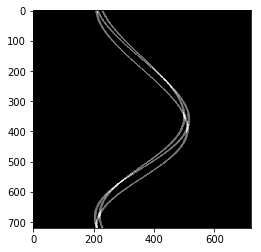

In [23]:
inputs = target * mask
import cv2
plt.imshow(test[:,152:-152],cmap='gray')

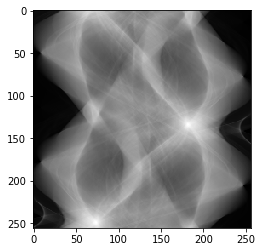

In [24]:
target=target[:,152:-152]
target=cv2.resize(target,(256,256))
plt.imshow(target,cmap='gray')
save

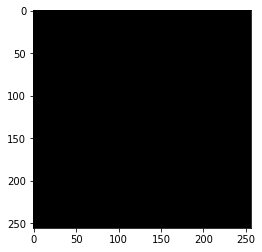

In [26]:
b=inputs[152,-512]
a=cv2.resize(b,(256,256))
plt.imshow(a,cmap='gray')